<a href="https://colab.research.google.com/github/GiX7000/object-detection/blob/main/YOLOv3_on_ImageNet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Yolo v3 on a subset of ImageNet

Use of the official [darknet's (pjreddie)](https://github.com/AlexeyAB/darknet) implementation.

In [1]:
# download Darknet's repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14997, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 14997 (delta 18), reused 31 (delta 12), pack-reused 14951
Receiving objects: 100% (14997/14997), 13.41 MiB | 25.01 MiB/s, done.
Resolving deltas: 100% (10183/10183), done.


In [2]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [3]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [4]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [5]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [6]:
# let's check if the model works by running a detection

# get yolov3 pretrained coco dataset weights for detection
!wget https://pjreddie.com/media/files/yolov3.weights

# with -thresh 0.8 in the below command, we can easily change the threshold of detected objects 
!./darknet detect cfg/yolov3.cfg yolov3.weights data/eagle.jpg


--2021-04-30 15:21:29--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  44.8MB/s    in 5.6s    

2021-04-30 15:21:35 (42.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 con

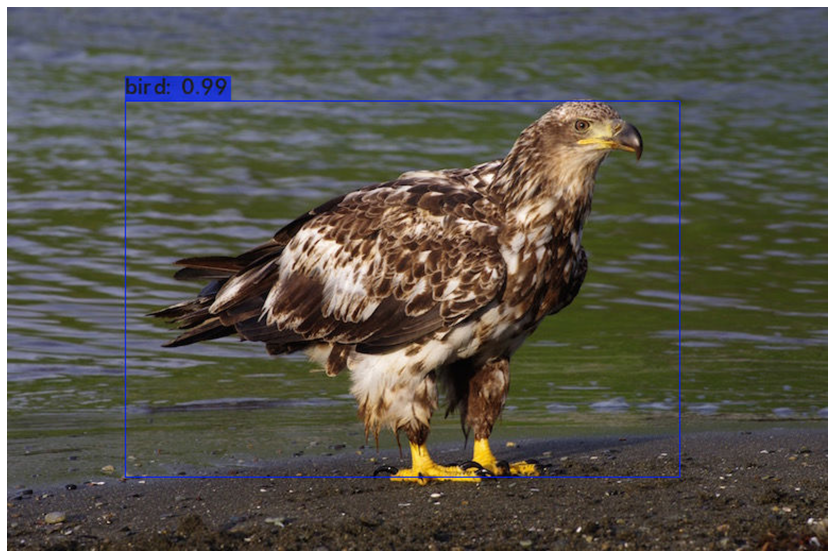

In [7]:
# show image using our helper function
imShow('predictions.jpg')

In [ ]:
# This stops 'Run all' at this cell by causing an error
#assert False

In [8]:
# get dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# all necessary files in one dir
%cd /content/drive/MyDrive
!mkdir my_yolov3

/content/drive/MyDrive


Images_set4 is a subset of ImageNet, which is comprised of 4 classes with maximum 45 images each for train set and another 10 for test set, respectively. More at ImageNet_Subset.ipynb.

In [11]:
# copy images_set4 to our working folder
!cp -r images_set4 /content/drive/MyDrive/my_yolov3/

We need to Configure training by changing/creating 5 things: modify yolov3.cfg, create data_names and my_data files and create train.txt and test.txt.



In [12]:
# modify yolov3.cfg
%cd /content/darknet/cfg
!cp yolov3.cfg /content/drive/MyDrive/my_yolov3

/content/darknet/cfg


Changes in yolov3.cfg file:

-batch=64
-subdivisions=16
-max_batches=8000 # 2000 per class
-steps=6400, 7200 #80%, 90% of max_batches
-at each [yolo], classes=4 and filters just above it filters=27 #(classes+5)*3

In [14]:
# create train_set and test_set so as they contain jpg and txt files for every image
%cd /content/drive/MyDrive/my_yolov3

!mkdir train_set
!mkdir test_set

# use XmlToTxt repo to convert ImageNet's xmls to txts
!git clone https://github.com/Isabek/XmlToTxt.git
!pip install declxml==0.9.1

/content/drive/MyDrive/my_yolov3
Cloning into 'XmlToTxt'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 99 (delta 26), reused 27 (delta 13), pack-reused 43
Unpacking objects: 100% (99/99), done.


In [18]:
%cd /content/drive/MyDrive/my_yolov3/XmlToTxt

# modify classes.txt for generating txt files
labels = ['cow', 'horse,Equuscaballus', 'sheep', 'person,individual,someone,somebody,mortal,soul']
with open('classes.txt', "w") as myfile:
    for i in labels:
      myfile.write(i)
      myfile.write('\n')

# create train set and test set in yolo format(jpg and txt files for every image)
!python xmltotxt.py -xml /content/drive/MyDrive/my_yolov3/images_set4/train -out /content/drive/MyDrive/my_yolov3/train_set

!python xmltotxt.py -xml /content/drive/MyDrive/my_yolov3/images_set4/test -out /content/drive/MyDrive/my_yolov3/test_set


/content/drive/MyDrive/my_yolov3/XmlToTxt


In [19]:
# check if all xml files converted successfully 
import os
print('train data')
print(len(os.listdir('/content/drive/MyDrive/my_yolov3/train_set')))
print(len(os.listdir('/content/drive/MyDrive/my_yolov3/images_set4/train'))/2)
print('test data')
print(len(os.listdir('/content/drive/MyDrive/my_yolov3/test_set')))
print(len(os.listdir('/content/drive/MyDrive/my_yolov3/images_set4/test'))/2)

train data
152
152.0
test data
38
38.0


In [21]:
# all images and txt files at one dir
%cd /content/drive/MyDrive/my_yolov3/images_set4/
import shutil

train_source = '/content/drive/MyDrive/my_yolov3/images_set4/train/'
test_source = '/content/drive/MyDrive/my_yolov3/images_set4/test/'
datasets_paths = [train_source, test_source]

for dataset_path in datasets_paths:
  for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg'):
      if dataset_path == train_source:
        shutil.move(dataset_path + filename, '/content/drive/MyDrive/my_yolov3/train_set')
      else:
        shutil.move(dataset_path + filename, '/content/drive/MyDrive/my_yolov3/test_set')


/content/drive/MyDrive/my_yolov3/images_set4


In [23]:
# create a label_map
%cd /content/drive/MyDrive/my_yolov3/
l = len(labels)

with open('data_names', 'w') as f:
    for label in labels:
        f.write(label)
        f.write('\n')

/content/drive/MyDrive/my_yolov3


In [35]:
# generate train.txt and test.txt files

image_files_train = []
image_files_test = []
os.chdir(os.path.join("/content/drive/MyDrive/my_yolov3", "train_set"))
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files_train.append('/content/drive/MyDrive/my_yolov3/train_set/' + filename)
os.chdir(os.path.join("/content/drive/MyDrive/my_yolov3", "test_set"))
for filename2 in os.listdir(os.getcwd()):
    if filename2.endswith(".jpg"):
        image_files_test.append('/content/drive/MyDrive/my_yolov3/test_set/' + filename2)
os.chdir("..")

with open("train.txt", "w") as outfile:
    for image in image_files_train:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
with open("test.txt", "w") as outfile:
    for image2 in image_files_test:
        outfile.write(image2)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

In [36]:
# create my_data file
%cd /content/drive/MyDrive/my_yolov3
!mkdir backup

with open('my_data', 'w') as f:
  f.write(str(l))
  f.write('\n')
  f.write('train=/content/drive/MyDrive/my_yolov3/train.txt')
  f.write('\n')
  f.write('valid=/content/drive/MyDrive/my_yolov3/test.txt')
  f.write('\n')
  f.write('names=/content/drive/MyDrive/my_yolov3/data_names')
  f.write('\n')
  f.write('backup=/content/drive/MyDrive/my_yolov3/backup')

# remove un-necessary files
!rm -rf XmlToTxt
!rm -rf images_set4

/content/drive/MyDrive/my_yolov3


In [27]:
# download pretrained weights for CNN
%cd /content/darknet/
!wget http://pjreddie.com/media/files/darknet53.conv.74

/content/darknet
URL transformed to HTTPS due to an HSTS policy
--2021-04-30 15:31:22--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  43.9MB/s    in 3.9s    

2021-04-30 15:31:26 (39.9 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [37]:
# train the model for 1000 iteration steps
%cd /content/darknet/
! ./darknet detector train /content/drive/MyDrive/my_yolov3/my_data /content/drive/MyDrive/my_yolov3/yolov3.cfg darknet53.conv.74 -map -dont_show #2>&1 > log.txt #| tee output.log

Streaming output truncated to the last 5000 lines.
 (next mAP calculation at 1000 iterations) 
 929: 0.609154, 0.492441 avg loss, 0.000745 rate, 5.532309 seconds, 59456 images, 11.919222 hours left
Loaded: 0.000041 seconds
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.705440), count: 3, class_loss = 0.841401, iou_loss = 0.219190, total_loss = 1.060592 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.631254), count: 2, class_loss = 0.224550, iou_loss = 0.238837, total_loss = 0.463387 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000032, iou_loss = 0.000000, total_loss = 0.000032 
 total_bbox = 75957, rewritten_bbox = 1.069026 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.779251), count: 6, class_loss = 0.278537, iou_loss = 0.327614, total_loss = 0.606151 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 

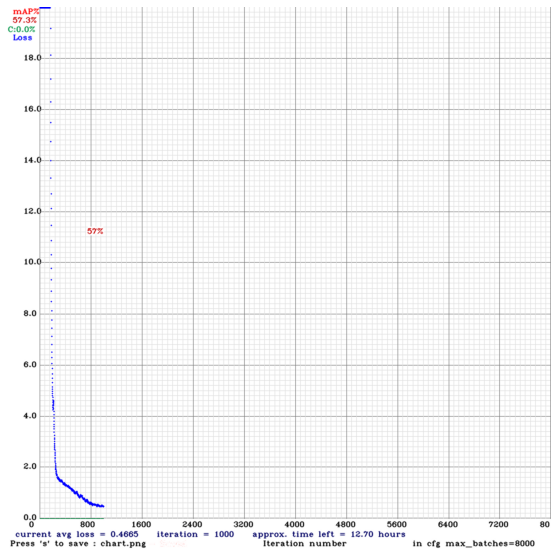

In [38]:
imShow('chart.png')

In [40]:
# evaluation 

! ./darknet detector map /content/drive/MyDrive/my_yolov3/my_data /content/drive/MyDrive/my_yolov3/yolov3.cfg /content/drive/MyDrive/my_yolov3/backup/yolov3_1000.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

In [41]:
# test the model over unseen images

# need to set our custom cfg to test mode 
%cd /content/drive/MyDrive/my_yolov3
!sed -i 's/batch=64/batch=1/' yolov3.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3.cfg

/content/drive/MyDrive/my_yolov3


/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sho

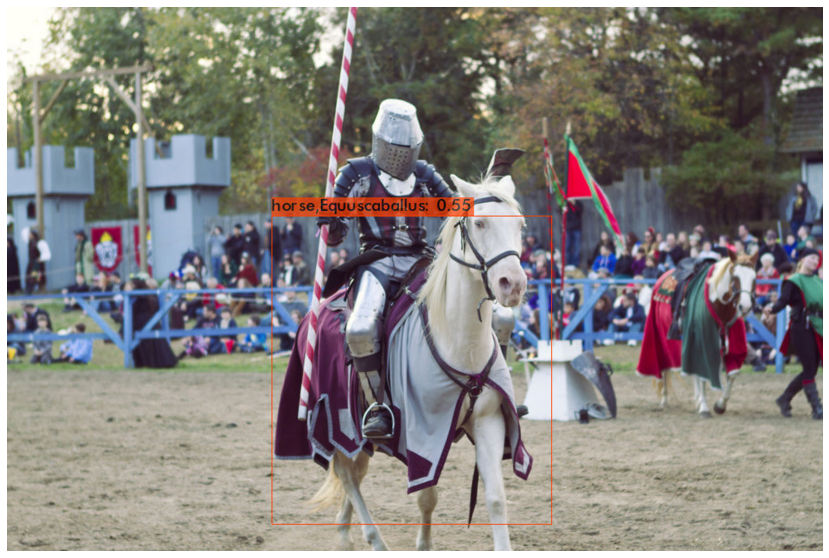

In [61]:
# run the inference
%cd /content/darknet
! ./darknet detector test /content/drive/MyDrive/my_yolov3/my_data /content/drive/MyDrive/my_yolov3/yolov3.cfg /content/drive/MyDrive/my_yolov3/backup/yolov3_1000.weights /content/drive/MyDrive/knight.jpg -thresh 0.5 -dont_show #-dont_show -ext_output < data/test.txt > data/results.txt #-out myfile
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

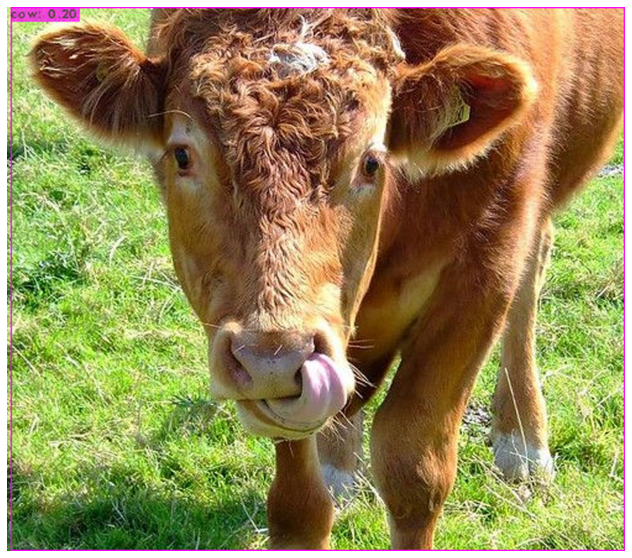

In [77]:
! ./darknet detector test /content/drive/MyDrive/my_yolov3/my_data /content/drive/MyDrive/my_yolov3/yolov3.cfg /content/drive/MyDrive/my_yolov3/backup/yolov3_1000.weights /content/drive/MyDrive/images_set4/test/n01887787_182.jpg -thresh 0.2 -dont_show #-dont_show -ext_output < data/test.txt > data/results.txt #-out myfile
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

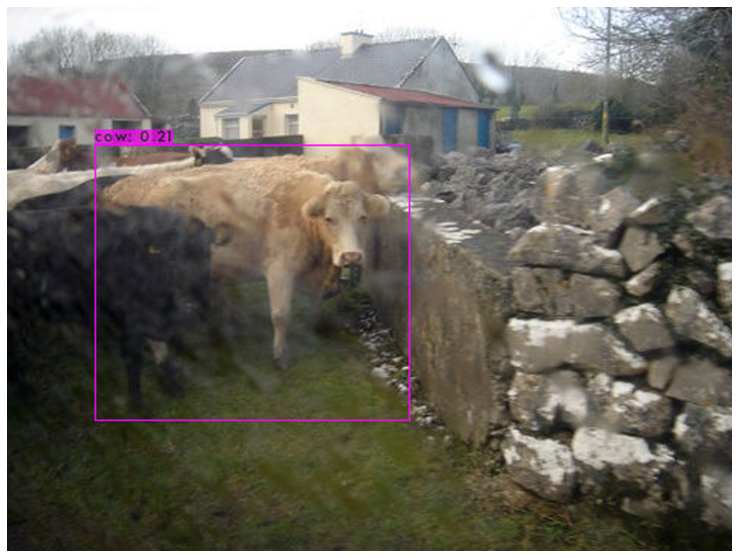

In [76]:
! ./darknet detector test /content/drive/MyDrive/my_yolov3/my_data /content/drive/MyDrive/my_yolov3/yolov3.cfg /content/drive/MyDrive/my_yolov3/backup/yolov3_1000.weights /content/drive/MyDrive/images_set3b/test/2007_004500.jpg -thresh 0.2 -dont_show #-dont_show -ext_output < data/test.txt > data/results.txt #-out myfile
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

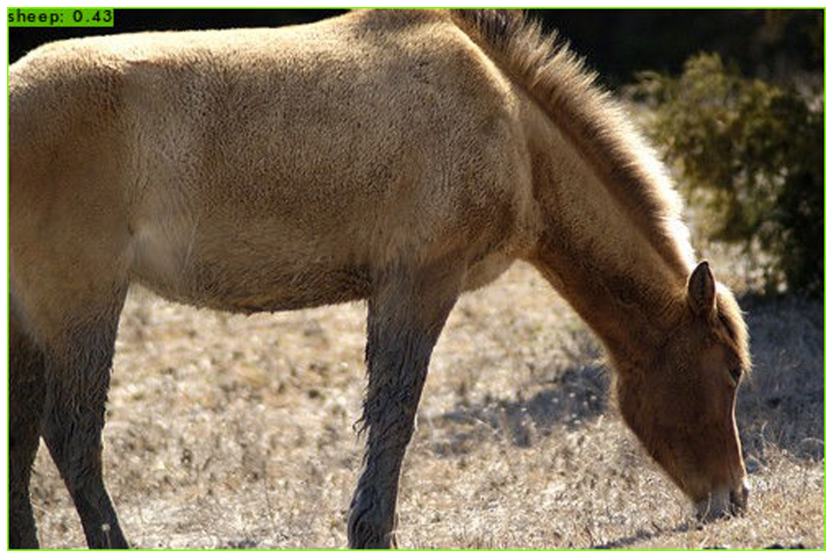

In [78]:
! ./darknet detector test /content/drive/MyDrive/my_yolov3/my_data /content/drive/MyDrive/my_yolov3/yolov3.cfg /content/drive/MyDrive/my_yolov3/backup/yolov3_1000.weights /content/drive/MyDrive/images_set4/test/n02374451_245.jpg -thresh 0.2 -dont_show #-dont_show -ext_output < data/test.txt > data/results.txt #-out myfile
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

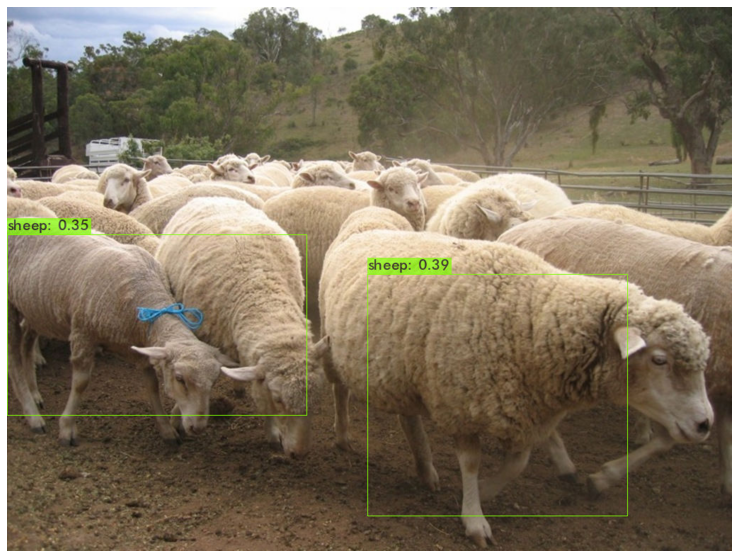

In [83]:
! ./darknet detector test /content/drive/MyDrive/my_yolov3/my_data /content/drive/MyDrive/my_yolov3/yolov3.cfg /content/drive/MyDrive/my_yolov3/backup/yolov3_1000.weights /content/drive/MyDrive/sheeps.jpg -thresh 0.1 -dont_show #-dont_show -ext_output < data/test.txt > data/results.txt #-out myfile
imShow('predictions.jpg')